# SPOTlight tutorial (taken from the website)
[Link here](https://marcelosua.github.io/SPOTlight/articles/SPOTlight_kidney.html#workflow)

## Installing packages

Some of these packages are used only for the tutorial, since they provide sample datasets to use. These will be shown separately.

In [1]:
library(SPOTlight)
library(rhdf5)
Sys.setenv(RETICULATE_PYTHON = "/media/gambino/students_workdir/ibp/gautam/miniconda3/envs/r_kernel/bin/python")
library(reticulate)
use_condaenv(condaenv = "r_kernel", conda  = "/media/gambino/students_workdir/ibp/gautam/miniconda3/bin/conda")
library(anndata)
library(SpatialExperiment)
library(SingleCellExperiment)
library(scater)
library(scran)
library(zellkonverter)
library(Seurat)
library(dplyr)
library(Matrix)
library(ggcorrplot)
library(Polychrome)

Loading required package: SingleCellExperiment

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘matrixStats’


The following objects are masked from ‘package:Biobase’:

    anyMissing, rowMedians



Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCums

In [5]:
spe <- read10xVisium(
  samples = "/media/gambino/students_workdir/ibp/visium_data/Slide2-3/1345_start-EP/outs",
  sample_id = "1345_start-EP",
  type = "HDF5",
  data = "filtered",
  images = "hires",
  load = FALSE
)

In [3]:
spe

class: SpatialExperiment 
dim: 36601 4305 
metadata(0):
assays(1): counts
rownames(36601): ENSG00000243485 ENSG00000237613 ... ENSG00000278817
  ENSG00000277196
rowData names(1): symbol
colnames(4305): AAACAACGAATAGTTC-1 AAACAAGTATCTCCCA-1 ...
  TTGTTTCCATACAACT-1 TTGTTTGTGTAAATTC-1
colData names(4): in_tissue array_row array_col sample_id
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):
spatialCoords names(2) : pxl_col_in_fullres pxl_row_in_fullres
imgData names(4): sample_id image_id data scaleFactor

In [6]:
rownames(spe) <- rowData(spe)$symbol

In [26]:
adata <- read_h5ad("/media/gambino/students_workdir/ibp/new_exploded_categories.h5ad")

In [34]:
length(unique((adata$obs)$category))

[1] 18

In [6]:
unique((adata$obs)$Region)

[1] SmallInt   LargeInt   APD        lymph node REC       
Levels: APD LargeInt REC SmallInt lymph node

In [27]:
intestine_idx <- which((adata$obs)$Region == "SmallInt")

In [28]:
count_matrix <- adata$X

In [29]:
new_obs <- adata$obs

In [30]:
counts_int <- count_matrix[intestine_idx, ]

In [31]:
obs_int <- new_obs[intestine_idx, ]

In [32]:
markers_df <- read.csv("/media/gambino/students_workdir/ibp/new_exploded_categories.csv")

In [33]:
head(markers_df)

,X,gene_rank,cell_type,gene_name,z_score
,<int>,<int>,<chr>,<chr>,<dbl>
1,0,0,B cells,CD74,229.83934
2,1,0,Branch Neurons,TUBB2B,119.34534
3,2,0,Dendritic,CD74,86.71767
4,3,0,Endothelial,EGFL7,183.86946
5,4,0,Epithelial,EPCAM,446.49017
6,5,0,Glia,PLP1,128.26413


In [35]:
filtered_markers <- as_tibble(markers_df) %>% 
    filter(gene_name %in% rownames(spe)) %>% 
    #filter(z_score > 1.65)  %>% 
    filter(z_score > 1.645) %>% 
    group_by(cell_type)  %>%
    slice_max(z_score, n = 250)

In [36]:
nrow(filtered_markers)

[1] 4500

In [48]:
idx <- split(seq(nrow(counts_int)), obs_int$Integrated_05)
n_cells <- 50
cs_keep <- lapply(idx, function(i) {
    n <- length(i)
    if (n < n_cells)
        n_cells <- n
    sample(i, n_cells)
})


In [49]:
new_counts <- counts_int[unname(unlist(cs_keep)), ]
new_obs <- obs_int[unname(unlist(cs_keep)), ]
groups_to_use <- new_obs$category

In [50]:
counts_final <- as(t(new_counts), "CsparseMatrix")

In [52]:
res <- SPOTlight(
    x = counts_final,
    y = spe,
    groups = groups_to_use,
    mgs = as.data.frame(filtered_markers),
    #top_n = 50,
    hvg = NULL,
    weight_id = "z_score",
    group_id = "cell_type",
    gene_id = "gene_name",
    verbose = TRUE)

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 1.4 GiB”
Scaling count matrix

Seeding initial matrices

Training NMF model

Time for training: 36.69min

Deconvoluting mixture data



In [53]:
mat <- res$mat
mod <- res$NMF

In [48]:
class(mod)

[1] "NMFfit"
attr(,"package")
[1] "NMF"

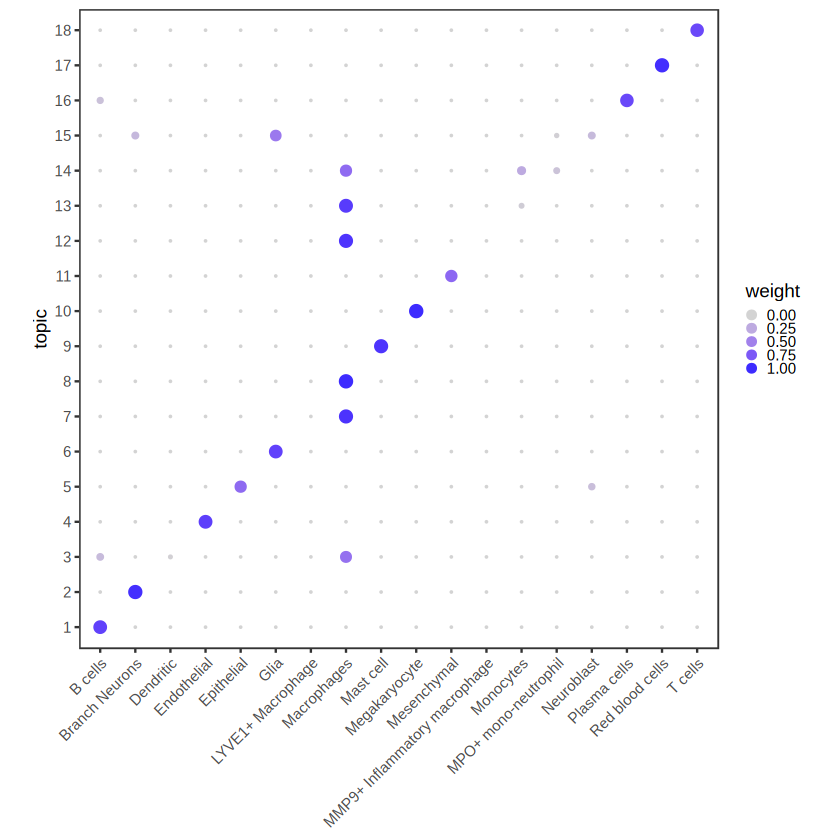

In [54]:
plotTopicProfiles(
    x = mod,
    y = groups_to_use,
    facet = FALSE,
    min_prop = 0.01,
    ncol = 1) +
    theme(aspect.ratio = 1)

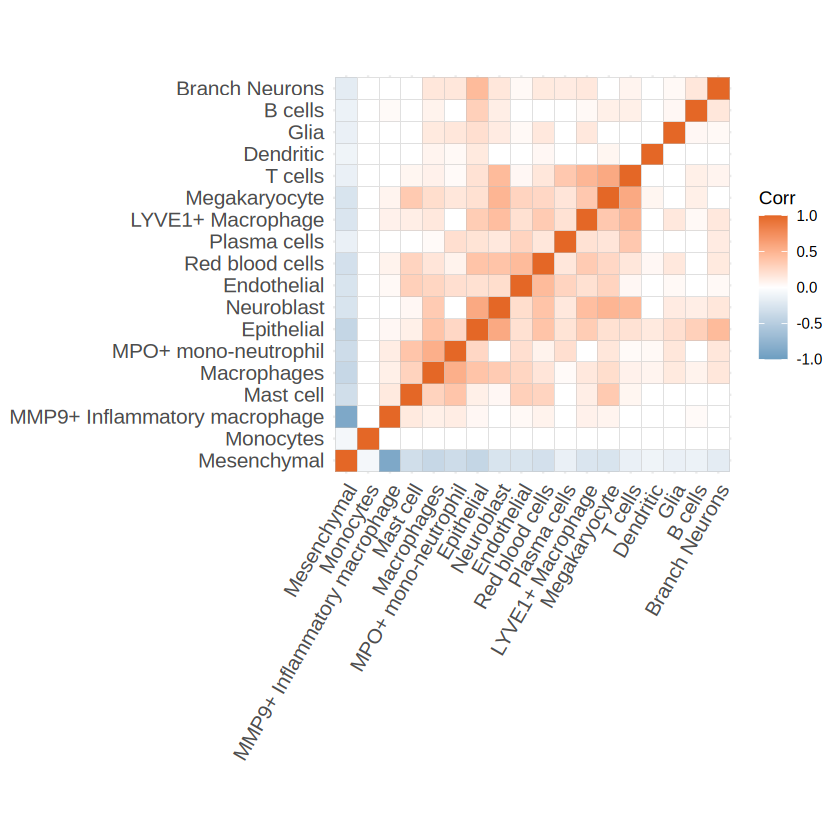

In [55]:
plotCorrelationMatrix(mat)

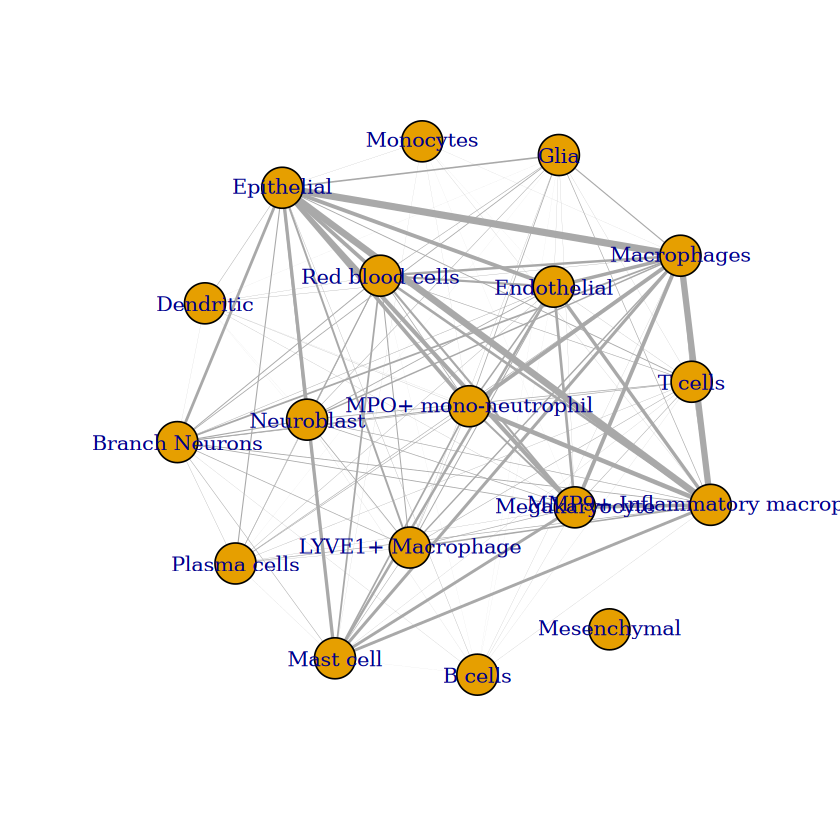

In [56]:
plotInteractions(mat, "network")

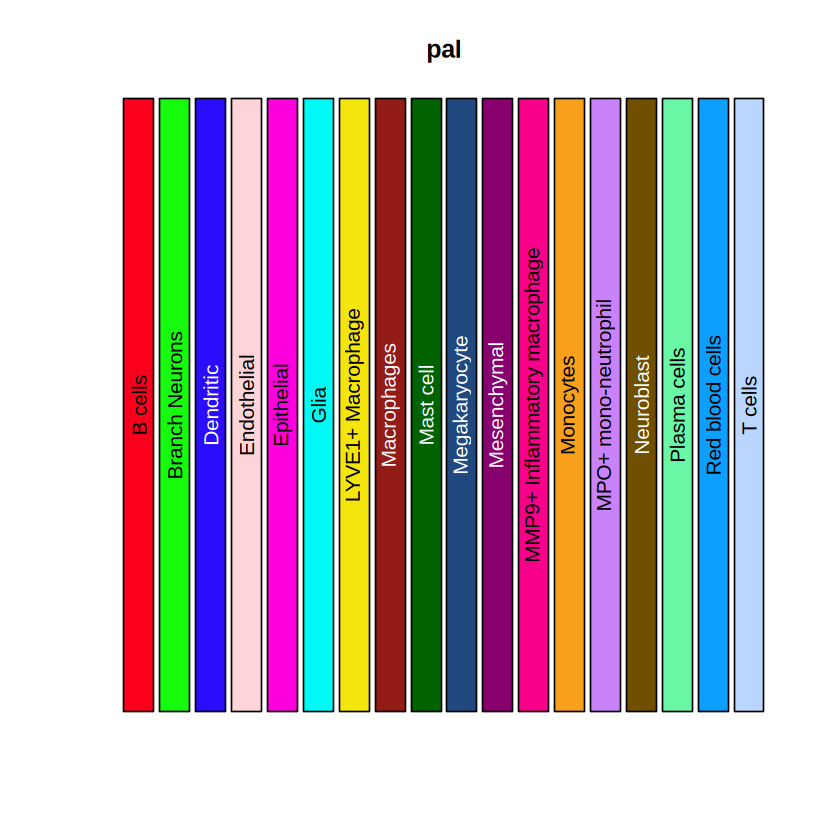

In [57]:
ct <- colnames(mat)

#mat[mat < 0.1] <- 0

pal = createPalette(length(ct),  c("#ff0000", "#00ff00", "#0000ff"))
names(pal) <- ct
swatch(pal)


In [28]:
neuroblast_flag <- grepl(c("neuroblast"), tolower(ct), fixed = TRUE)
neuroblast_flag[16] <- TRUE
glia_flag <- grepl("glia", tolower(ct), fixed = TRUE)
glia_flag[16] <- FALSE
neuron_flag <- grepl("branch", tolower(ct), fixed = TRUE)
dendritic_flag <- grepl("DC", ct, fixed = TRUE)
mast_flag <- grepl("Mast", ct, fixed = TRUE)


In [39]:
pal[neuroblast_flag] <- pal[which(neuroblast_flag)[1]]
pal[glia_flag] <- pal[which(glia_flag)[1]]
pal[neuron_flag] <- pal[which(neuron_flag)[1]]
pal[dendritic_flag] <- pal[which(dendritic_flag)[1]]
pal[mast_flag] <- pal[which(mast_flag)[1]]

In [58]:
scatterpie_new <- plotSpatialScatterpie(
    x = spe,
    y = mat,
    cell_types = colnames(mat),
    img = TRUE,
    scatterpie_alpha = 1,
    pie_scale = 0.4,
    axis = "h",
    degrees = 270) +
    scale_fill_manual(
        values = pal, 
        breaks = names(pal)
        ) +
    guides(color = guide_legend(override.aes = list(size = 0.5)))

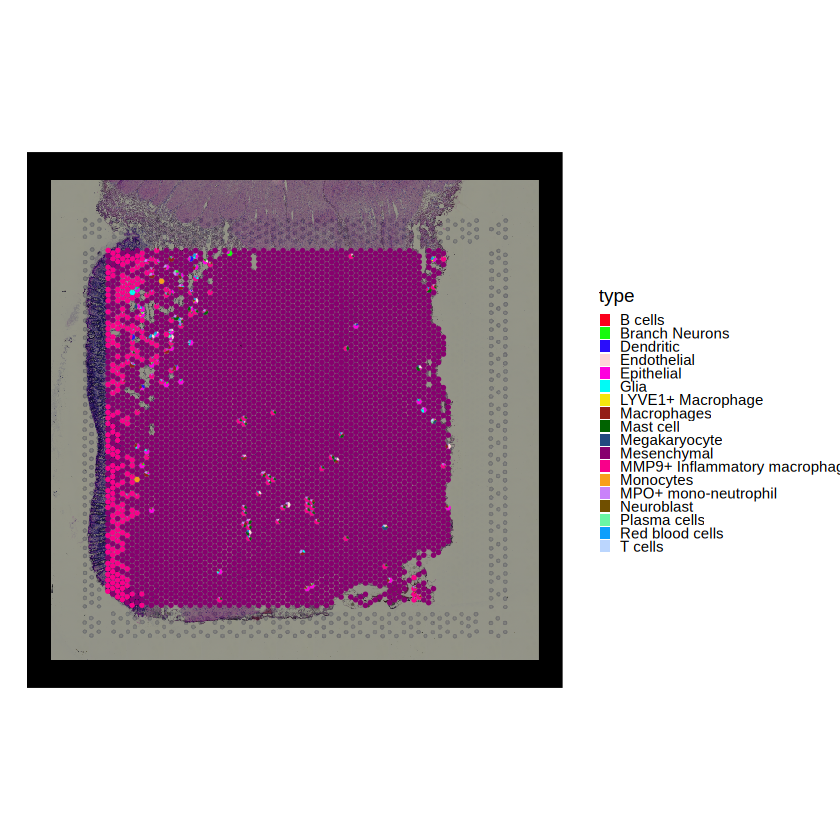

In [59]:
scatterpie_new

In [75]:
ggsave(plot = scatterpie_new, file = "/media/gambino/students_workdir/ibp/gautam_images/scatterpie_all_markers_tissue.svg")

Saving 6.67 x 6.67 in image


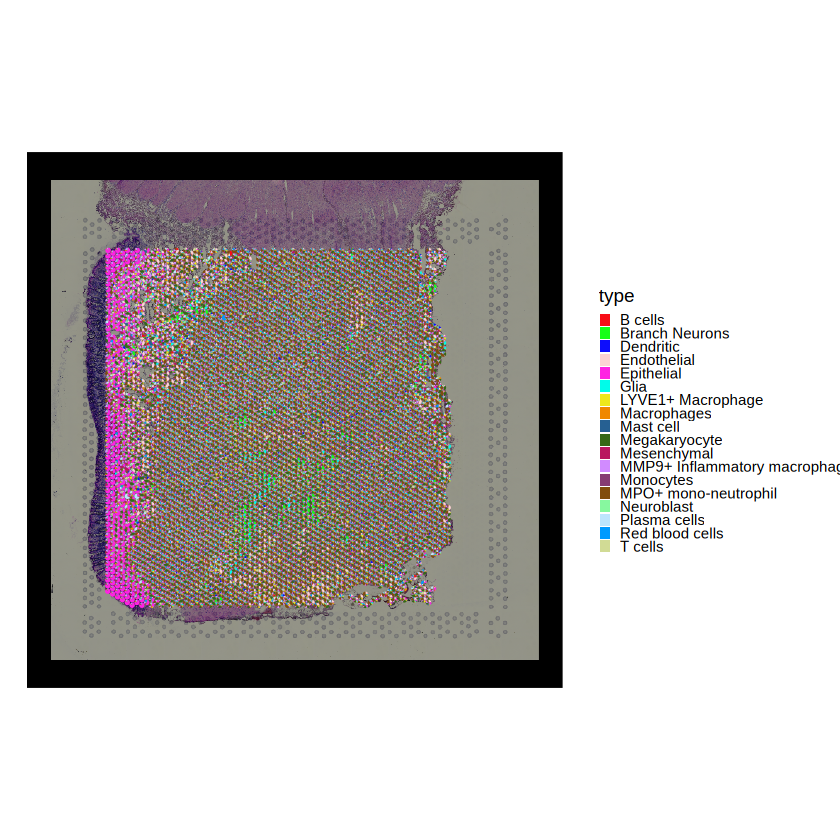

In [73]:
scatterpie_new

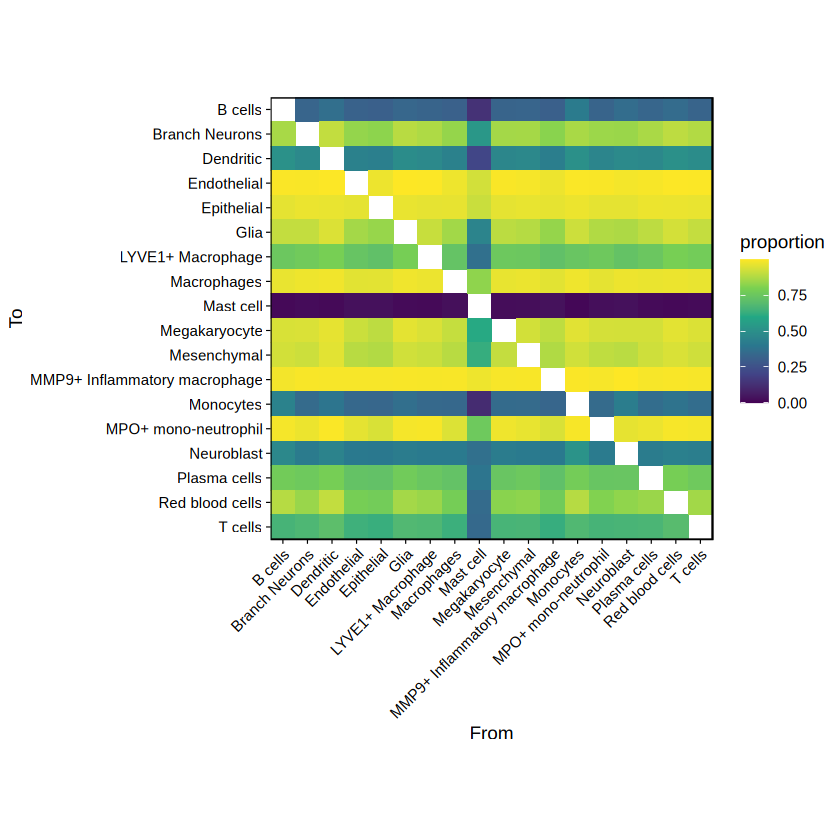

In [57]:
plotInteractions(mat, which = "heatmap", metric = "prop")

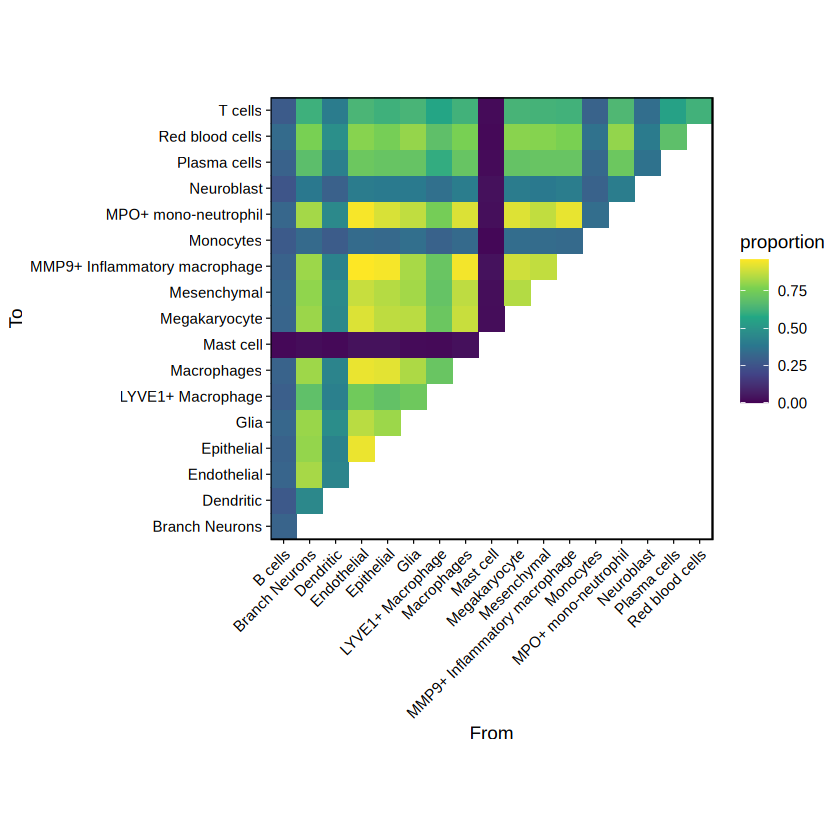

In [60]:
plotInteractions(mat, which = "heatmap", metric = "jaccard")

In [80]:
spe$res_ss <- res[[2]][colnames(spe)]
xy <- spatialCoords(spe)
spe$x <- xy[, 1]
spe$y <- xy[, 2]
res_ss_plot <- ggcells(spe, aes(x, y, color = res_ss)) +
    geom_point(alpha = 1) +
    scale_color_viridis_c() +
    coord_fixed() +
    theme_bw()

In [81]:
ggsave(plot = res_ss_plot, file = "/media/gambino/students_workdir/ibp/gautam_images/res_ss_all_markers_100.svg")

Saving 6.67 x 6.67 in image


In [2]:
cell2location_results <- read.csv("/media/gambino/students_workdir/nynke/results/results/explodedGut/1579_6cell_highconfidencemodel.csv")

In [17]:
cell2location_spe <- read10xVisium(
  samples = "/media/gambino/students_workdir/ibp/visium_data/Slide1/1579_deep/outs",
  sample_id = "1579_deep",
  type = "HDF5",
  data = "filtered",
  images = "hires",
  load = FALSE)

In [19]:
rownames(cell2location_spe) <- cell2location_spe$symbol

In [20]:
rownames(cell2location_results) <- colnames(cell2location_spe)

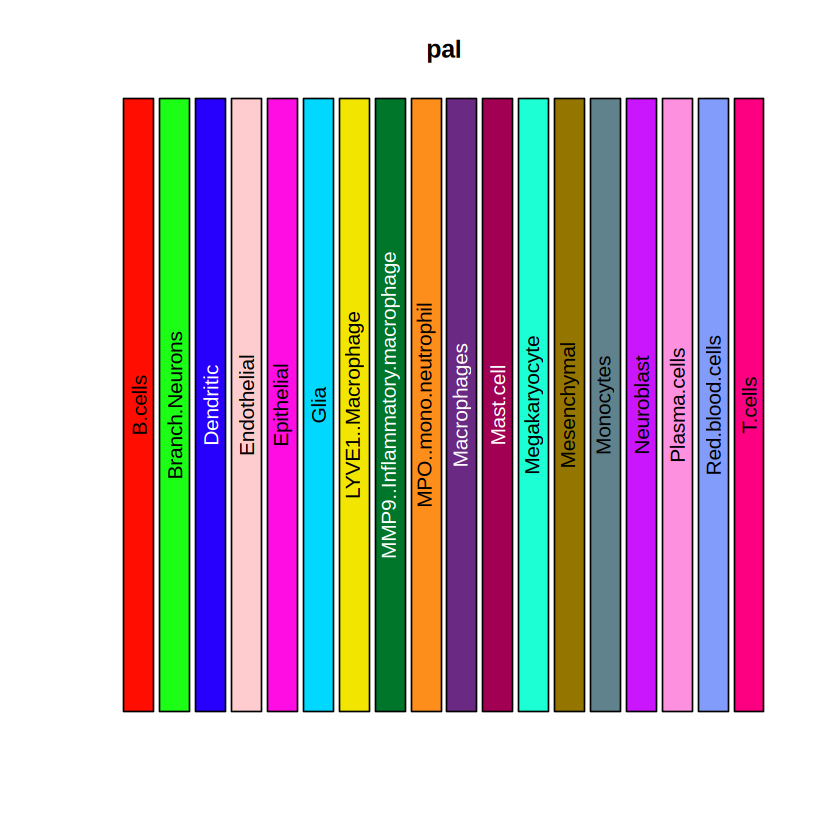

In [23]:
ct <- colnames(cell2location_results)

#mat[mat < 0.1] <- 0

pal = createPalette(length(ct),  c("#ff0000", "#00ff00", "#0000ff"))
names(pal) <- ct
swatch(pal)

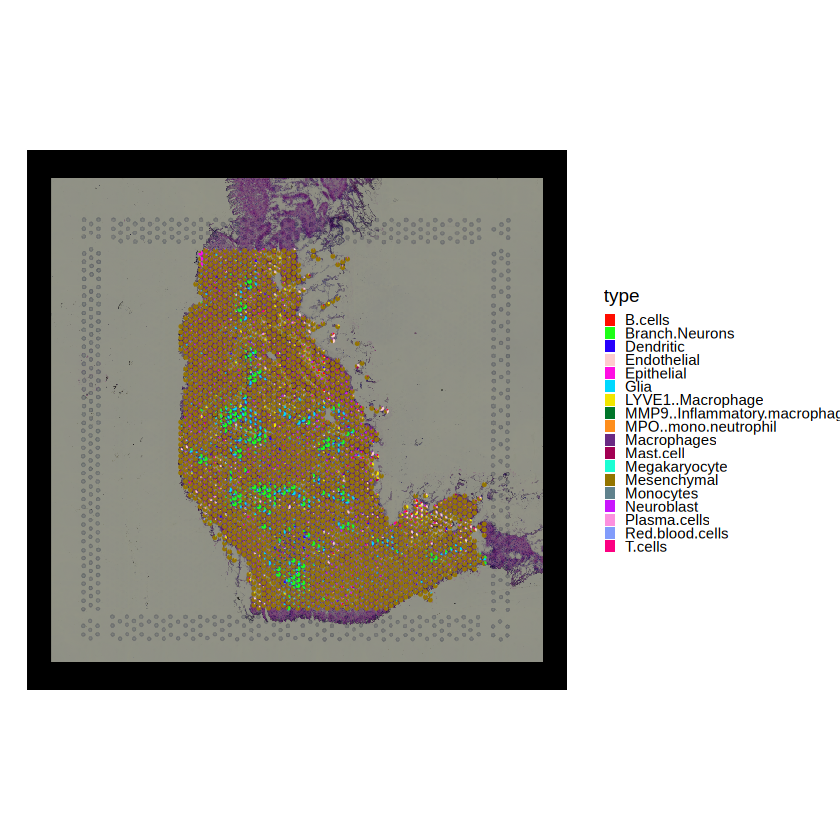

In [24]:
plotSpatialScatterpie(
    x = cell2location_spe,
    y = cell2location_results,
    cell_types = colnames(cell2location_results),
    img = TRUE,
    scatterpie_alpha = 1,
    pie_scale = 0.4,
    axis = "h",
    degrees = 270) +
    scale_fill_manual(
        values = pal, 
        breaks = names(pal)
        ) +
    guides(color = guide_legend(override.aes = list(size = 0.5)))

In [12]:
spotlight_res <- read.table("/media/gambino/students_workdir/ibp/spotlight_matrix_res_all_markers.txt")

In [14]:
length(rownames(spotlight_res))

[1] 4305

In [4]:
rownames(spe)

ERROR: Error in h(simpleError(msg, call)): error in evaluating the argument 'x' in selecting a method for function 'rownames': object 'spe' not found
